# SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

Let's generate our dataset and take a look on it.

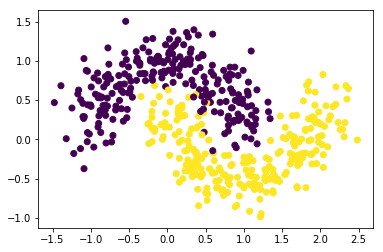

In [2]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [4]:
def extract_name(clf, params):
    name = str(clf).split('(')[0]
    p_name = ''
    for param in params:
        try:
            param_value = str(clf).split(param + '=')[1].split(',')[0]
            p_name += param + '=' + param_value + ', '
        except:
            continue
    if len(p_name):
        name += '({})'.format(p_name[:-2])
    return name

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

lr = LogisticRegression(solver='lbfgs', penalty='l2', C=1) # add some params
svm = SVC(kernel='linear', C=1, probability=True) # here too

### YOUR CODE HERE

In [6]:
def plot_decisions(X, y, clfs, metric = {'name': 'ROCAUC', 'func': roc_auc_score},
                   c=1, n=500, figsize = None,
                   params=['C', 'kernel', 'penalty']):
    min_max = lambda x, c: (x.min(axis=0) - c, x.max(axis=0) + c)
    xy_min, xy_max = min_max(X, c)
    x_lin = np.linspace(xy_min[0], xy_max[0], n)
    y_lin = np.linspace(xy_min[1], xy_max[1], n)
    xv, yv = np.meshgrid(x_lin, y_lin)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)

    cmap = plt.get_cmap('Set3', y.max() + 1)
    # To pretty view
    if type(clfs) not in {list, np.ndarray}:
        clfs = [clfs]
    clfs = np.array(clfs)
    sh = clfs.shape
    assert len(sh) <= 2, 'Check inputs'
    if len(sh) == 1:
        sh = (1, sh[0])
    clfs.resize(sh)
    figsize = figsize or (8*sh[1], 8*sh[0])
    
    f, axs = plt.subplots(sh[0], sh[1], figsize=figsize)
    axs = np.array(axs).reshape(sh)
    
    for clf, ax in zip(clfs.reshape(-1), axs.reshape(-1)):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = metric['func'](y_test, y_pred)
        X_plot = np.vstack([xv.ravel(), yv.ravel()]).T
        y_plot = clf.predict(X_plot).reshape(xv.shape)

        ax.set_title(extract_name(clf, params) + ' ({}: {:.2f})'.format(metric['name'], score))
        ax.contourf(xv, yv, y_plot, cmap = cmap, alpha=.8)
        ax.scatter(X.T[0], X.T[1], c='black', s=30)
        ax.scatter(X.T[0], X.T[1], c=y, s=20, cmap=cmap)
    plt.show()

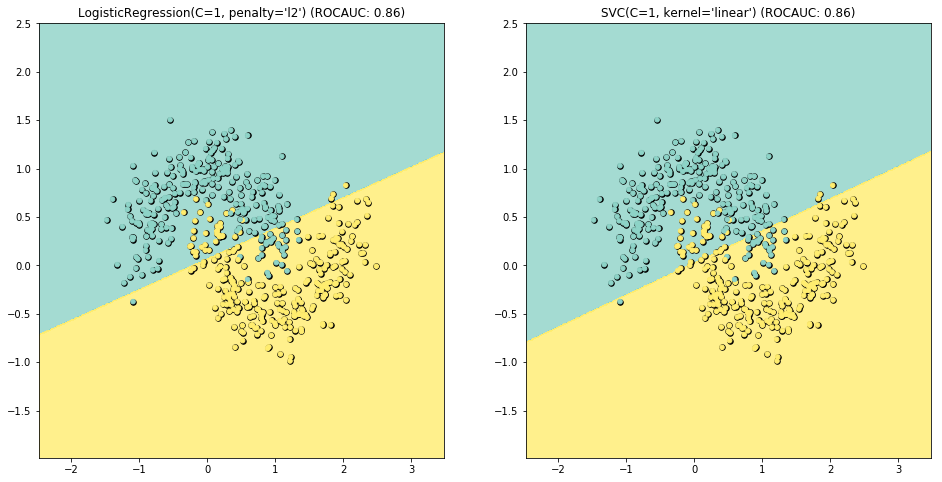

In [7]:
plot_decisions(moons_points, moons_labels, [lr, svm])

Хотя **Logistic Regression** и **SVM** решают разные оптимизационные задачи, в такой простой задаче они приходят к почти одинаковым оптимуам. Причем тут влияние параметра `С` не будет сильно влиять на этот оптимум, хотя бы потому, что выборки линейно не разделимы.

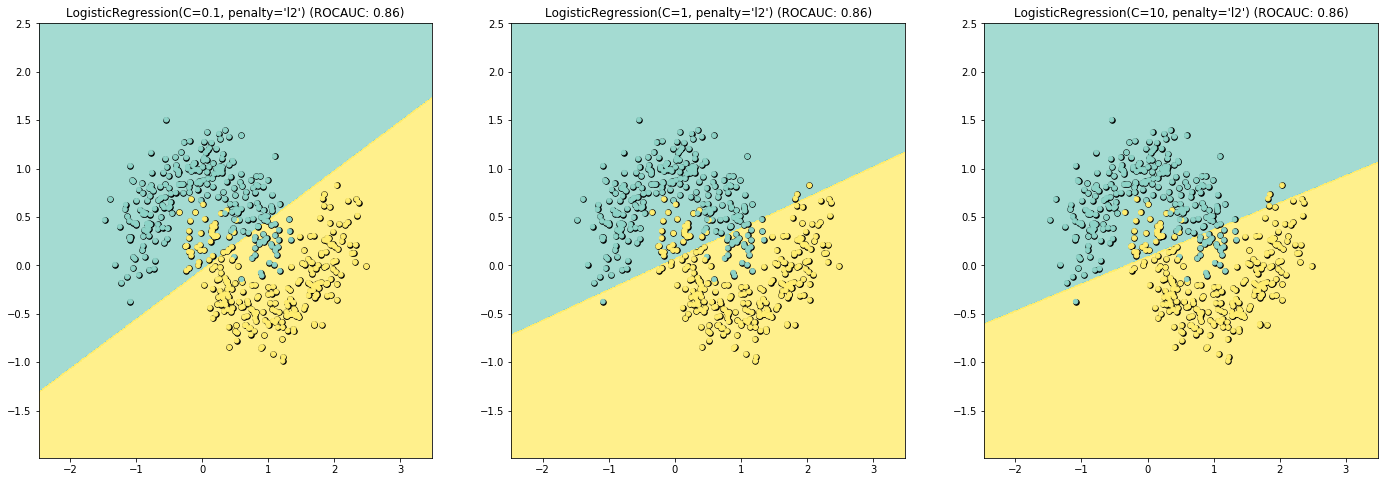

In [8]:
lrs = [LogisticRegression(solver='lbfgs', penalty='l2', C=0.1),
       LogisticRegression(solver='lbfgs', penalty='l2', C=1),
       LogisticRegression(solver='lbfgs', penalty='l2', C=10)]

plot_decisions(moons_points, moons_labels, lrs)

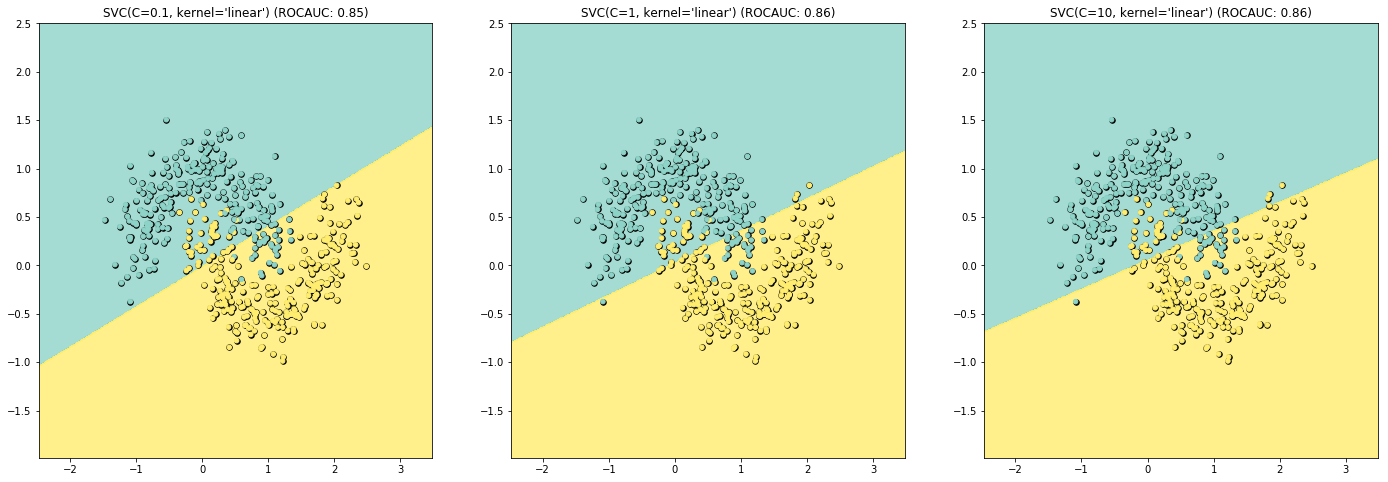

In [9]:
svms = [SVC(kernel='linear', C=0.1, probability=True),
        SVC(kernel='linear', C=1, probability=True),
        SVC(kernel='linear', C=10, probability=True)]

plot_decisions(moons_points, moons_labels, svms)

## 1.2 Kernel tirck

![keep-calm](imgs/keep-calm.jpg)

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

In [10]:
def make_grid_clfs(gen, param_grid):
    keys = param_grid.keys()
    ps1, ps2 = np.array(list(param_grid.values()))
    clfs = [[make_svm(dict(zip(keys, (p1, p2)))) for p1 in ps1] for p2 in ps2]
    clfs = np.array(clfs)
    return clfs

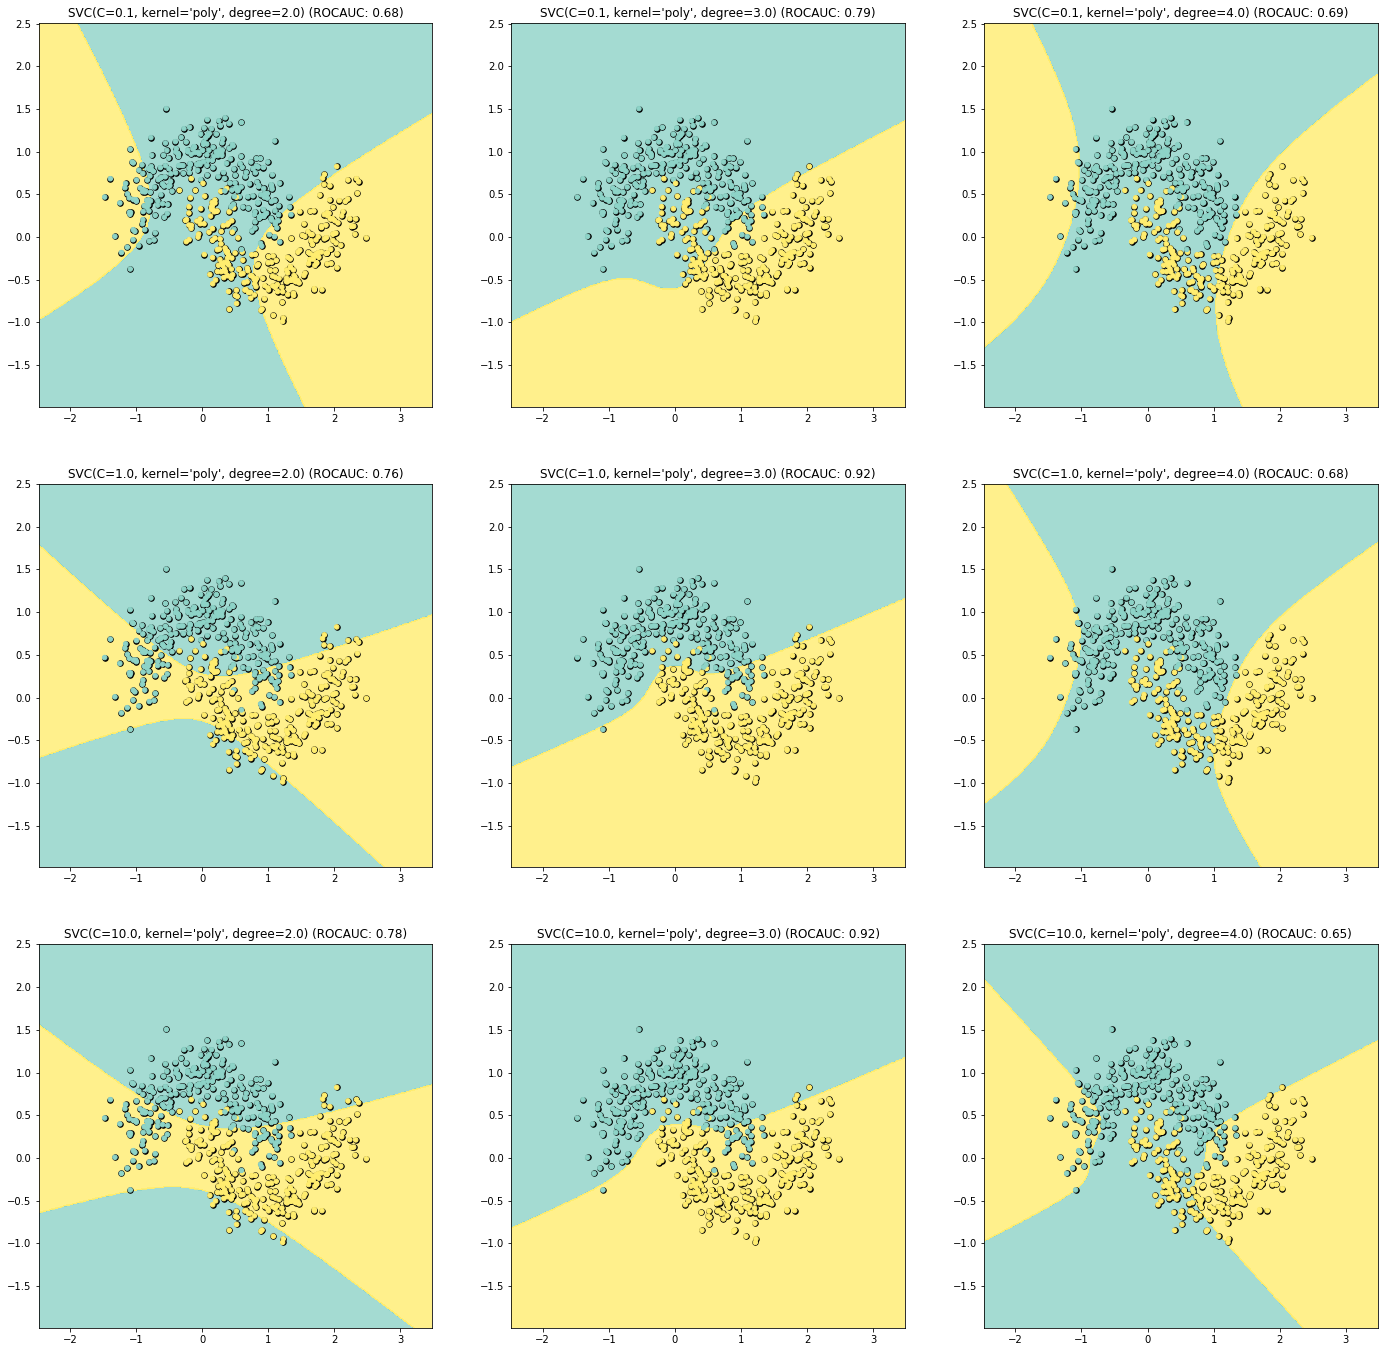

In [11]:
make_svm = lambda params: SVC(kernel='poly', gamma='scale', **params)
param_grid = {'degree': [2, 3, 4],
              'C': [0.1, 1, 10]}

clfs = make_grid_clfs(make_svm, param_grid)
plot_decisions(moons_points, moons_labels, clfs, params=['C', 'kernel', 'degree'])

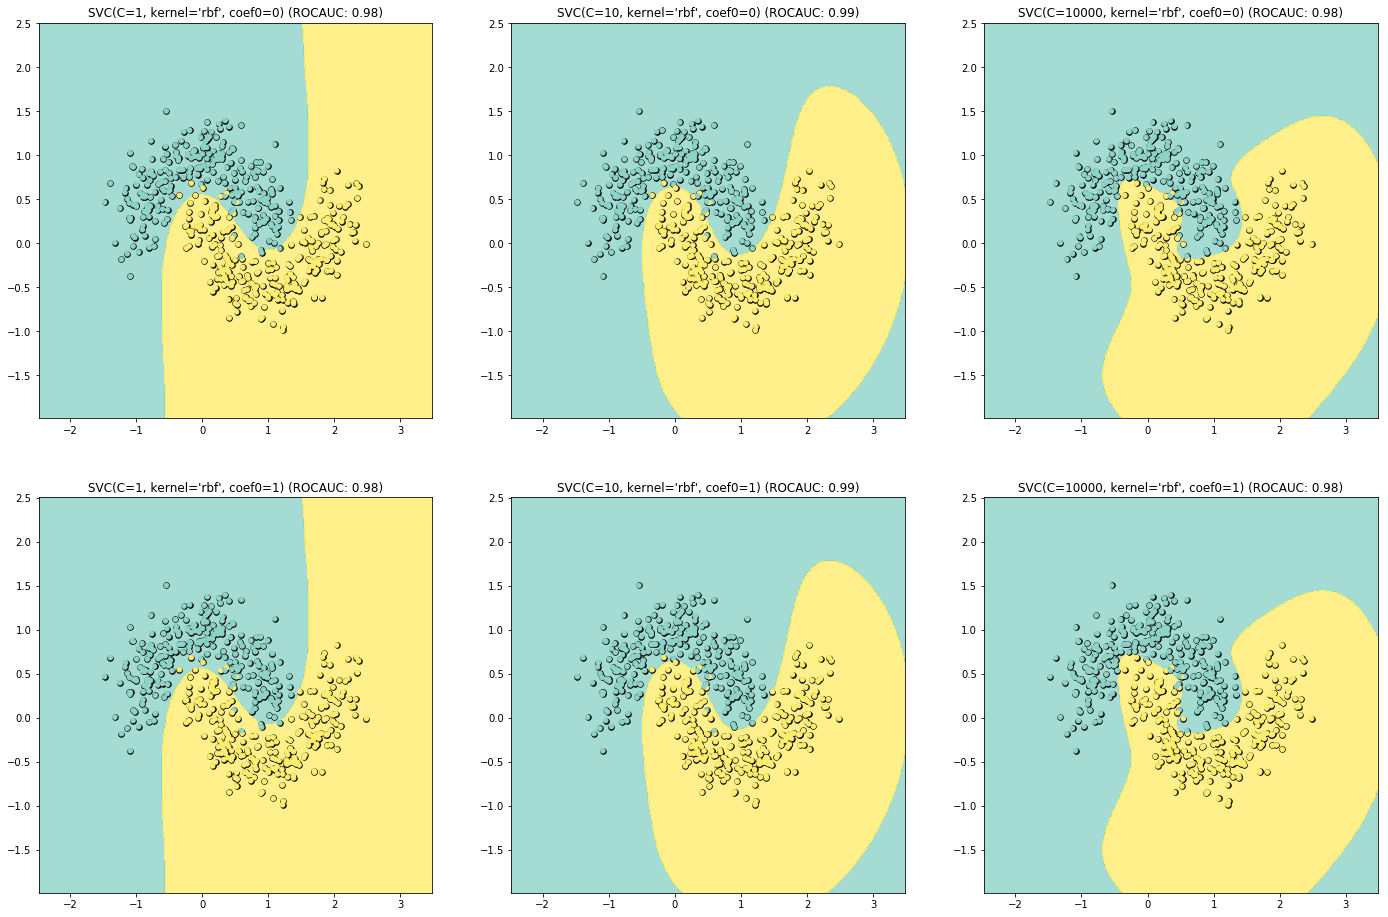

In [12]:
make_svm = lambda params: SVC(kernel='rbf', gamma='scale', **params)
param_grid = {'C': [1, 10, 10000],
              'coef0': [0, 1]}

clfs = make_grid_clfs(make_svm, param_grid)
plot_decisions(moons_points, moons_labels, clfs, params=['C', 'kernel', 'coef0'])

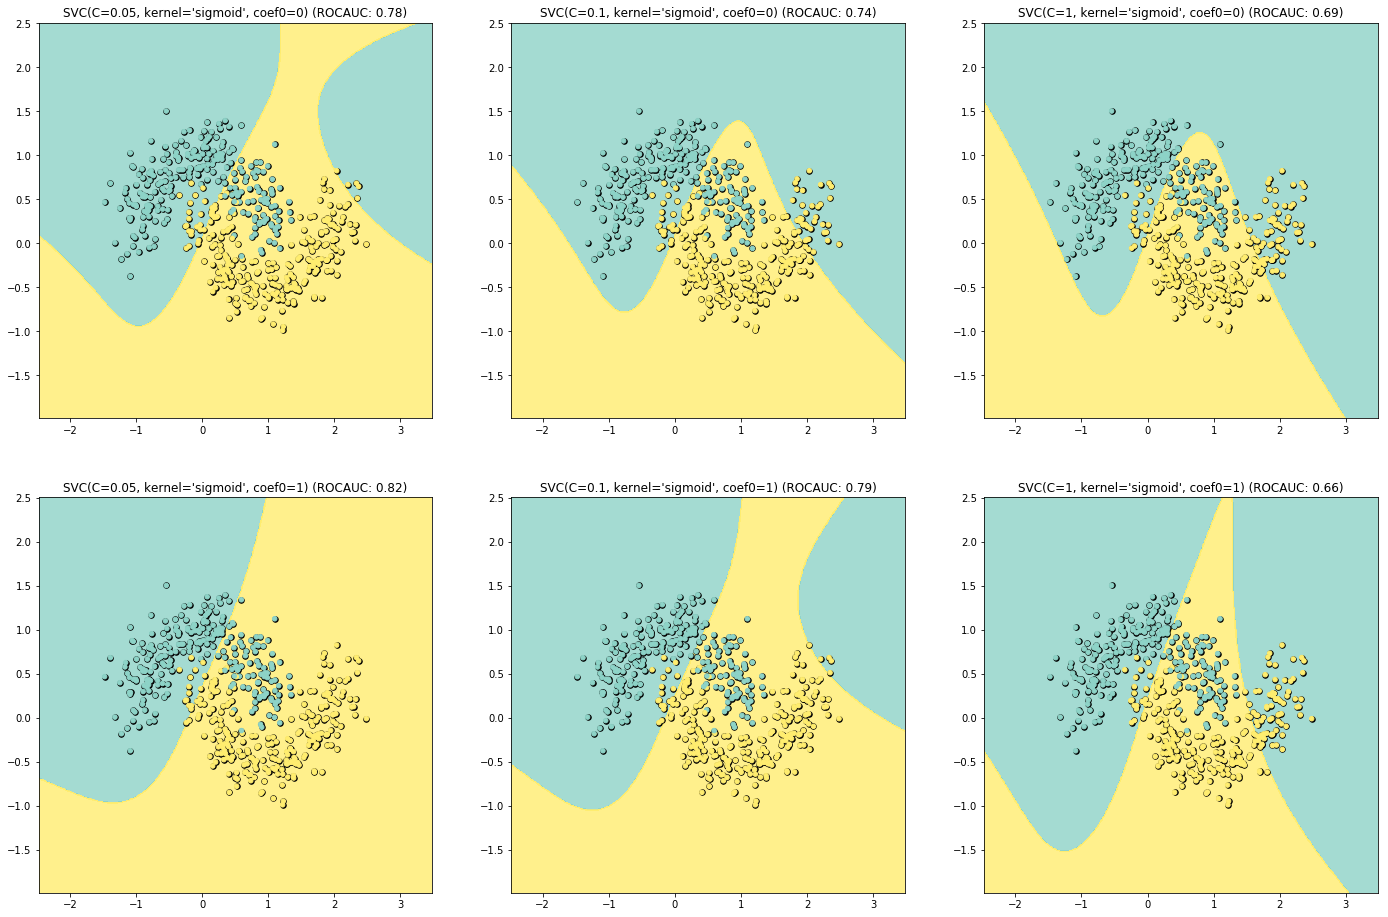

In [13]:
make_svm = lambda params: SVC(kernel='sigmoid', gamma='scale', **params)
param_grid = {'C': [0.05, 0.1, 1],
              'coef0': [0, 1]}

clfs = make_grid_clfs(make_svm, param_grid)
plot_decisions(moons_points, moons_labels, clfs, params=['C', 'kernel', 'coef0'])

Выбрав другое ядро, качество классификации выросло и изменились границы множест. Выбор нестандартного ядра - переход в другое пространсво (большое размерности). Такой метод позволяет с легкостью разделять линейно неразделимые выборки, при условии, что мы правильно подобрали ядро.

На этапе анализа, из-за структуры данных, можно сразу сделать вывод, что полиноминальное и сигмойдное ядро не подойдут в этой задаче, когда экспоненциальное ядро как никто лучше решит эту задачу. Если говорить только про полиноминальное ядро, с увеличением параметра `degree` растут степени свободы и поэтому такую задачу будет сложнее решать. Обычно пользуются не выскоими степенями. В наше 3 степень показала лучший результат.

## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

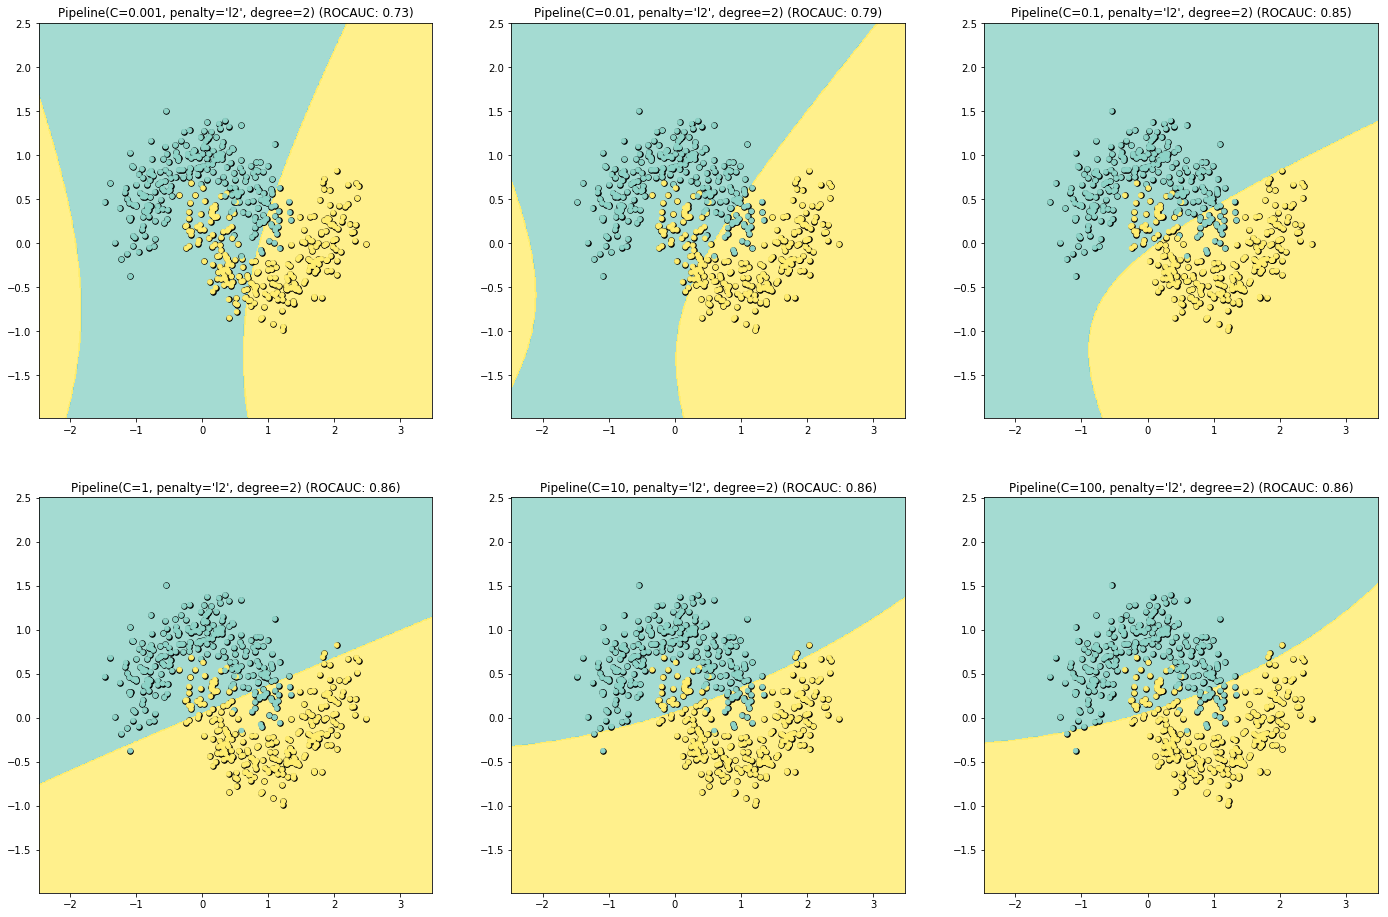

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

poly = PolynomialFeatures(2)

lrs = [[Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=0.001))]),
        Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=0.01))]),
        Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=0.1))])],
       [Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=1))]),
        Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=10))]),
        Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=100))])]]
       
plot_decisions(moons_points, moons_labels, lrs, params=['lr', 'C', 'penalty', 'degree'])

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


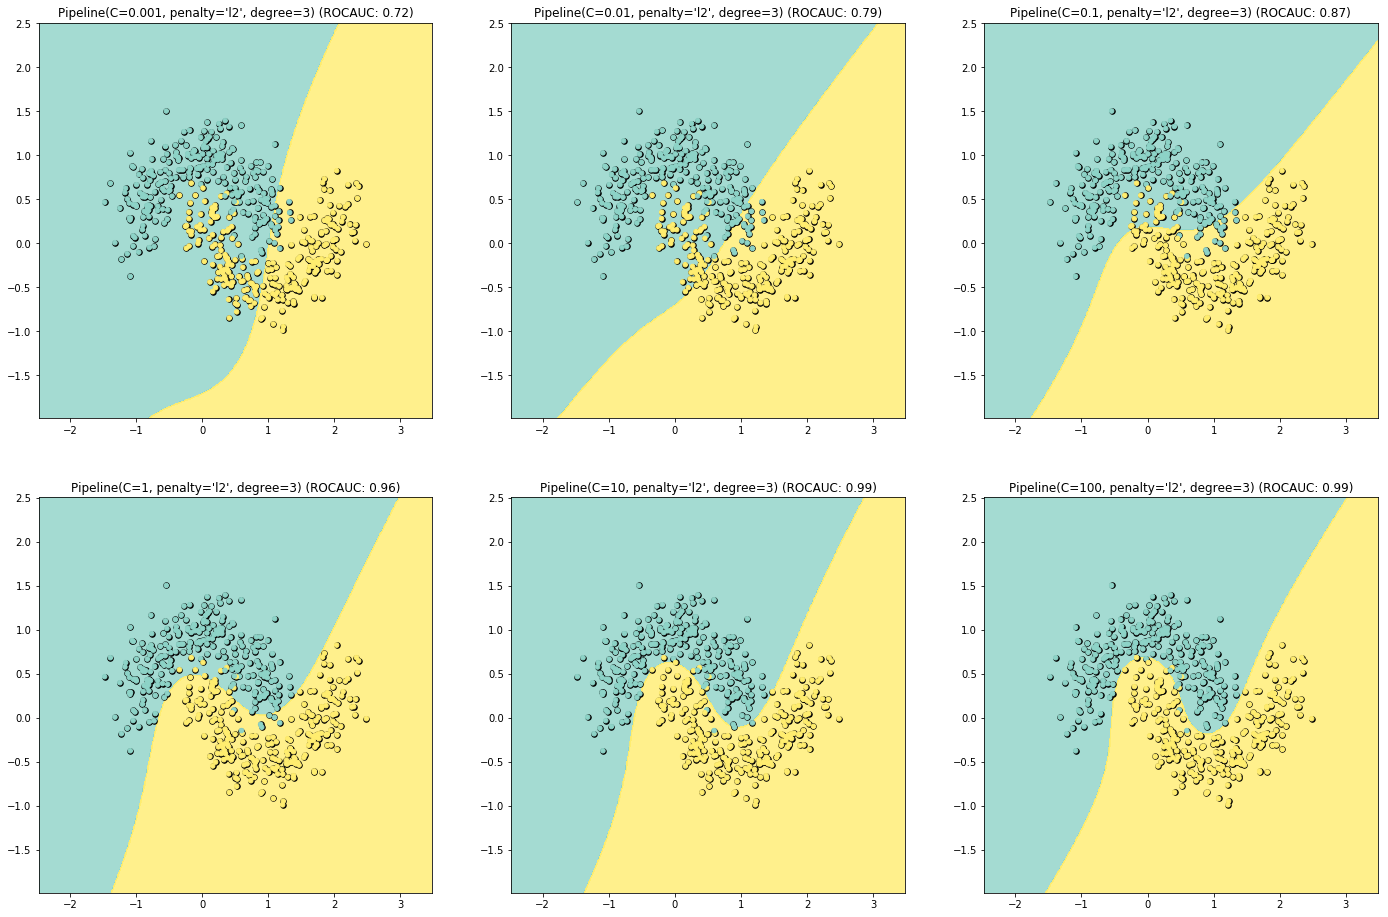

In [15]:
poly = PolynomialFeatures(3)
lrs = [[Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=0.001))]),
        Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=0.01))]),
        Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=0.1))])],
       [Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=1))]),
        Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=10))]),
        Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=100))])]]
       
plot_decisions(moons_points, moons_labels, lrs, params=['lr', 'C', 'penalty', 'degree'])

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


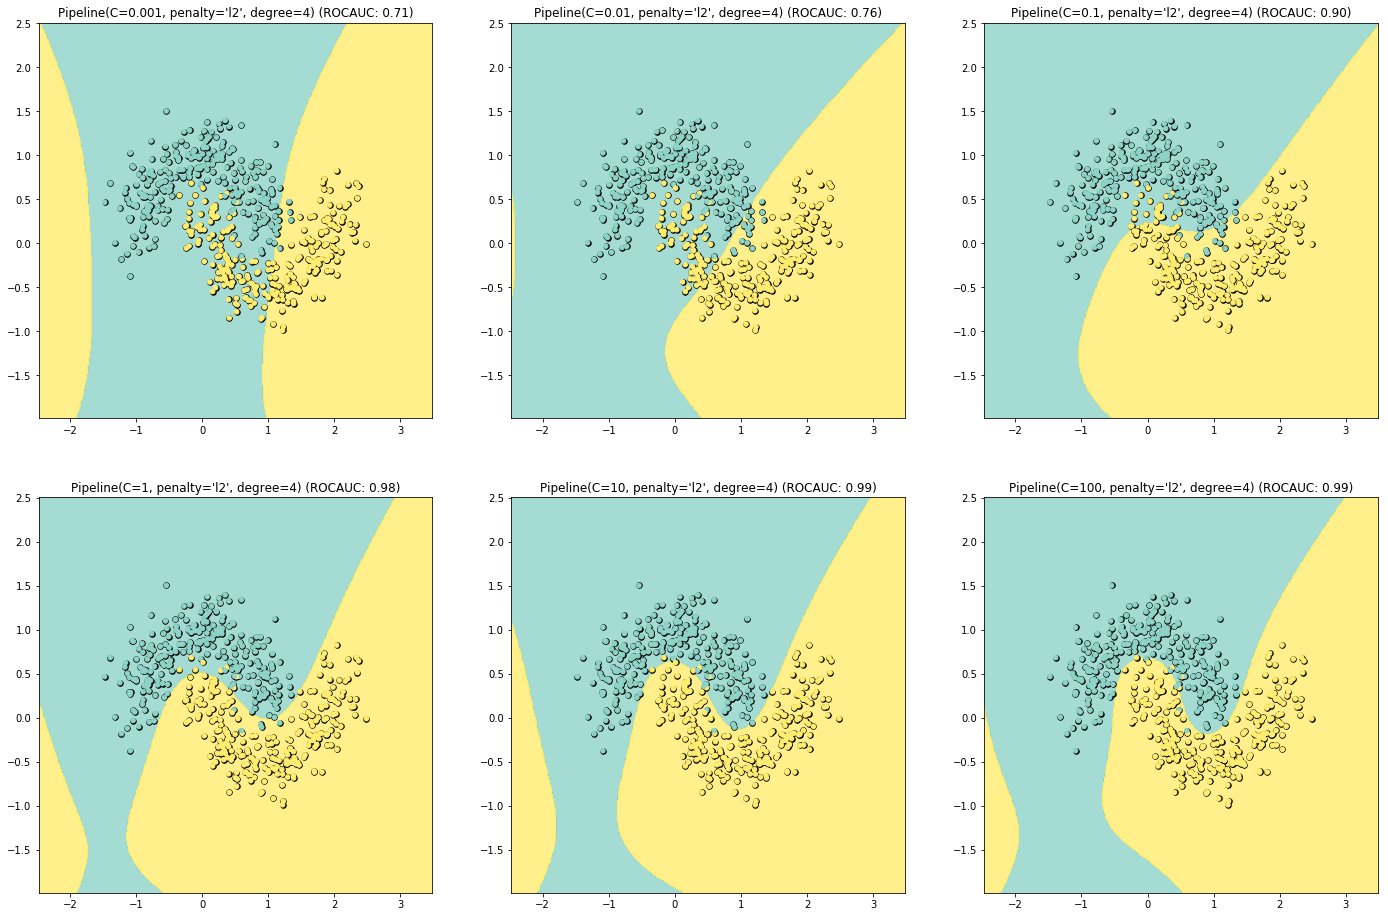

In [16]:
poly = PolynomialFeatures(4)

lrs = [[Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=0.001))]),
        Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=0.01))]),
        Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=0.1))])],
       [Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=1))]),
        Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=10))]),
        Pipeline( steps= [('poly', poly),
                          ('lr'  , LogisticRegression(solver='lbfgs', penalty='l2', C=100))])]]
       
plot_decisions(moons_points, moons_labels, lrs, params=['lr', 'C', 'penalty', 'degree'])

Как упоминалось ранее, **SVM** и **LR** решают разные оптимизационные задачи. В добавок к этому в **LR** параметр у каждого полиноминального признака свой и независимый от остальных (когда в **SVM** из-за скалярного произведения это не так). Поэтому границы множест и поменялись. А от туда и качество возросло.

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

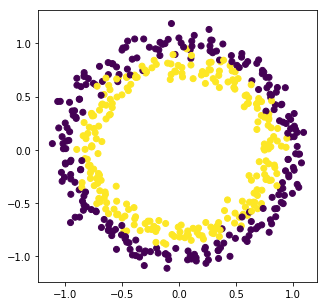

In [17]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)

And even more:

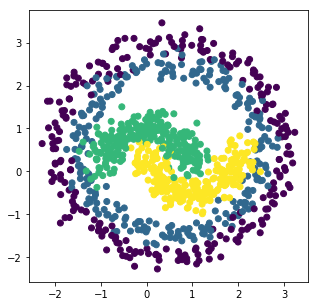

In [18]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels)

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

In [19]:
from sklearn.metrics import accuracy_score

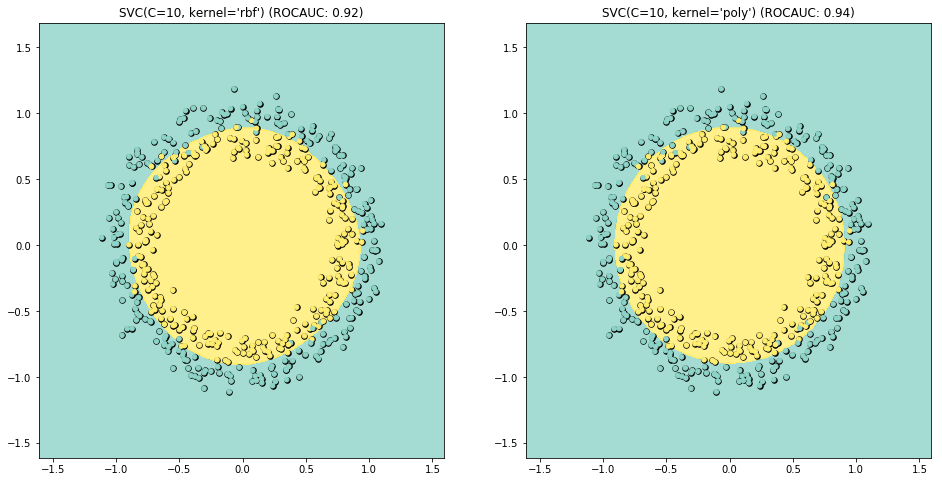

In [20]:
svms = [SVC(kernel='rbf', gamma='scale', C=10),
        SVC(kernel='poly', gamma='scale', degree=2, C=10)]

plot_decisions(circles_points, circles_labels, svms, c=0.5)

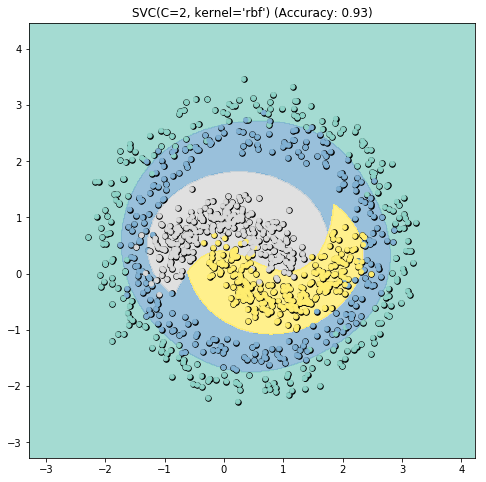

In [21]:
svm = SVC(kernel='rbf', gamma='scale', C=2)
plot_decisions(points, labels, svm, {'name': 'Accuracy', 'func': accuracy_score})

Нам опять повезло и из-за симметричной структуры данных использование экспоненциального ядра дает нам хороший результат.